# Model optimization


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Model evaluation

- Evaluate a model with some hyperparameter configuration
- Communicate results via reasonably chosen metrics   

In [3]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
X = dataset.data
Y = dataset.target

X = (X-X.mean())/X.std()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=42)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((455, 30), (114, 30), (455,), (114,))

In [4]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, Y_train)

knn.score(X_test, Y_test)

0.9122807017543859

In [6]:
from sklearn.metrics import classification_report

y_preds = knn.predict(X_test)

report = classification_report(Y_test, y_preds)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.90      0.88        42
           1       0.94      0.92      0.93        72

    accuracy                           0.91       114
   macro avg       0.90      0.91      0.91       114
weighted avg       0.91      0.91      0.91       114



roc_auc=0.9107
f1=0.9296


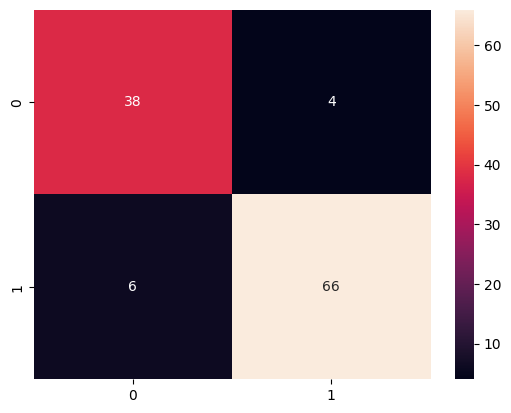

In [8]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

roc_auc = float(roc_auc_score(Y_test, y_preds))
f1 = float(f1_score(Y_test, y_preds))
cm = confusion_matrix(Y_test, y_preds)

sns.heatmap(cm, annot=True)

print(f"{roc_auc=:.4}")
print(f"{f1=:.4}")

## Factorial design (Grid search) with repeated train/test splits

- Repeatedly randomly split 
- Exhaustive search over a grid of hyperparameter configurations

In [9]:
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1, 16)
num_random_splits = 20
res = {}

for k in k_range:

    mean_conf_res = []
    for rs in range(num_random_splits):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=rs)

        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, Y_train)
        y_preds = knn.predict(X_test)

        roc_auc = float(roc_auc_score(Y_test, y_preds))

        mean_conf_res.append(roc_auc)
    
    res[k] = sum(mean_conf_res)/num_random_splits

res

{1: 0.9128968253968255,
 2: 0.9180059523809524,
 3: 0.9286210317460318,
 4: 0.9305555555555556,
 5: 0.9314484126984126,
 6: 0.9346230158730158,
 7: 0.9299107142857143,
 8: 0.9321924603174603,
 9: 0.9294642857142857,
 10: 0.9341269841269841,
 11: 0.9274305555555555,
 12: 0.9342261904761905,
 13: 0.928125,
 14: 0.930059523809524,
 15: 0.923611111111111}

Text(0, 0.5, 'Mean ROC AUC score')

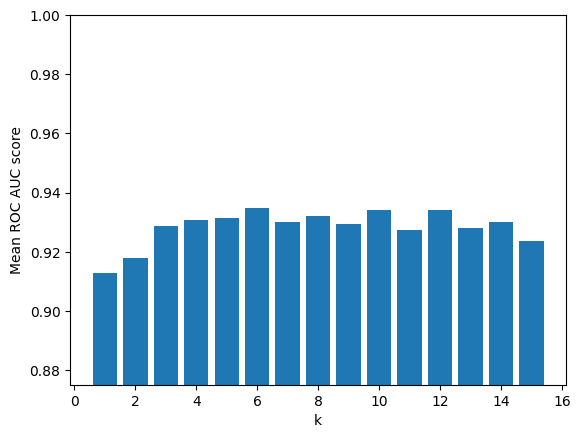

In [10]:
plt.bar(res.keys(), res.values())
plt.ylim(0.875, 1.0)
plt.xlabel('k')
plt.ylabel('Mean ROC AUC score')

## Randomized design (Random search) with repeated train/test splits

In [11]:
import random
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

num_rand_k = 15
k_range = range(1, 65)
num_random_splits = 20
res = {}

for _ in range(num_rand_k):
    k = random.choice(k_range)

    mean_conf_res = []
    for rs in range(num_random_splits):
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=rs)

        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train, Y_train)
        y_preds = knn.predict(X_test)

        roc_auc = float(roc_auc_score(Y_test, y_preds))

        mean_conf_res.append(roc_auc)
    
    res[k] = sum(mean_conf_res)/num_random_splits

res

{36: 0.9138392857142857,
 39: 0.9125,
 22: 0.9254960317460318,
 34: 0.9132440476190476,
 62: 0.9050099206349206,
 24: 0.9239583333333334,
 11: 0.9274305555555555,
 20: 0.9258928571428571,
 30: 0.9185019841269841,
 37: 0.9118055555555555,
 56: 0.9062003968253969,
 44: 0.9096726190476192}

Text(0, 0.5, 'Mean ROC AUC score')

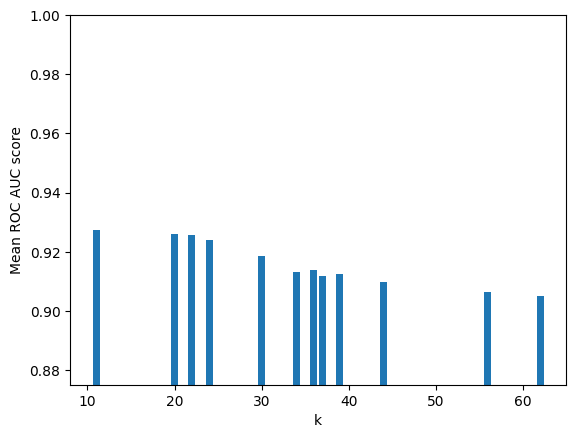

In [12]:
plt.bar(res.keys(), res.values())
plt.ylim(0.875, 1.0)
plt.xlabel('k')
plt.ylabel('Mean ROC AUC score')

## K-fold Cross-validation

In [14]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier

# definer scorer
roc_auc_scorer = make_scorer(roc_auc_score)

# define num folds
k_folds = 10

# define model
model = KNeighborsClassifier(n_neighbors=3)

# cross-validate
scores = cross_val_score(model, X_train, Y_train, cv=k_folds, scoring=roc_auc_scorer)
scores

array([0.90669371, 0.90669371, 0.89452333, 0.95334686, 0.94117647,
       0.95273109, 0.92331933, 0.84663866, 0.85294118, 0.90546218])

In [15]:
scores.mean()

np.float64(0.9083526514053897)

In [16]:
model.fit(X_train, Y_train)
y_preds = model.predict(X_test)

roc_auc_score(Y_test, y_preds)

np.float64(0.9146825396825398)

### Grid search CV

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': range(1, 16)
}

# define model
model = KNeighborsClassifier()
gscv = GridSearchCV(model, param_grid, scoring=roc_auc_scorer, cv=k_folds).fit(X_train, Y_train)

gscv.best_params_, gscv.best_score_

/home/jan/programming/python-dev/ZM001-2425-data-science/.venv/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


({'n_neighbors': 7}, np.float64(0.9265683859750796))

In [18]:
y_preds = gscv.best_estimator_.predict(X_test)
roc_auc_score(Y_test, y_preds)

np.float64(0.9265873015873016)

### Random search CV

In [19]:
from sklearn.model_selection import RandomizedSearchCV

param_distr = {
    'n_neighbors': range(1, 100)
}

# define model
model = KNeighborsClassifier()
rscv = RandomizedSearchCV(model, param_distr, n_iter=50, scoring=roc_auc_scorer, cv=k_folds).fit(X_train, Y_train)

rscv.best_params_, rscv.best_score_

({'n_neighbors': 6}, np.float64(0.9230766444508838))

In [20]:
y_preds = rscv.best_estimator_.predict(X_test)
roc_auc_score(Y_test, y_preds)

np.float64(0.9265873015873016)

## Optimize multiple hyperparameters

Example
- Apply PCA with $d$ principal components
- Apply KNN with $k$ neighbours

In [21]:
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

res = []

# test all possible d values
for d in range(1, X.shape[1]+1):

    # test k for all (1, ..., 15)
    for k in range(1, 16):

        X_train_pca = PCA(n_components=d).fit_transform(X_train)
        knn = KNeighborsClassifier(n_neighbors=k).fit(X_train_pca, Y_train)

        X_test_pca = PCA(n_components=d).fit_transform(X_test)
        y_preds_pca = knn.predict(X_test_pca)
        
        auc = roc_auc_score(Y_test, y_preds_pca)
        res.append([d, k, auc])

<Axes: xlabel='d', ylabel='k'>

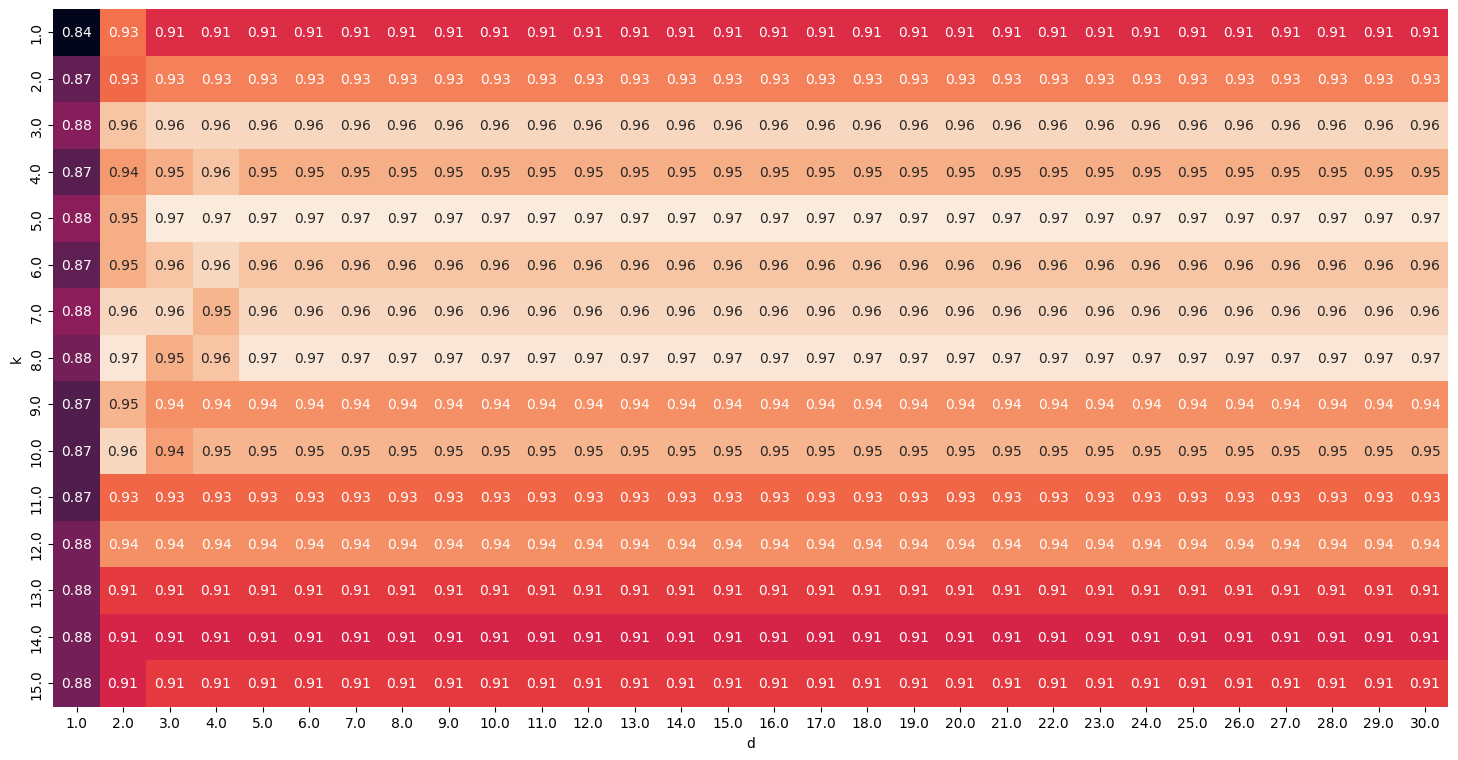

In [22]:
res_df = pd.DataFrame(np.array(res), columns=['d', 'k', 'AUC'])

res_df_pivot = res_df.pivot(index='k', columns='d', values='AUC')

fig, ax = plt.subplots(figsize=(18, 18))
sns.heatmap(ax=ax, data=res_df_pivot, cbar=False, annot=True, square=True, fmt=".2f")

## Central Limit Theorem

Repeated averages of samples tend towards a **normal distribution**

In [29]:
dice = range(1, 6*num_dice)

dice

range(1, 60)

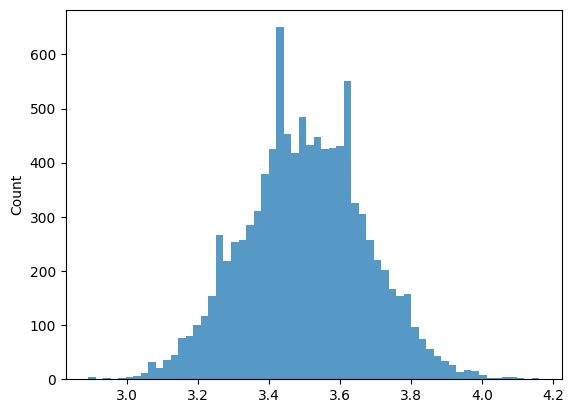

In [45]:
# how many die are we throwing
num_dice = 1
# how big is each sample of dice throws
sample_size = 100
# how many samples are we taking
num_samples = 10000

# dice possibilities for each die
dice = range(1, 6*num_dice+1)#[1, 2, 3, 4, 5, 6] * num_dice

mean_samples = []

for _ in range(num_samples):
    # take random sample of sample_size
    sample = np.random.choice(dice, size=sample_size)
    # append mean of random sample 
    mean_samples.append(sample.mean())

# plot histogram
sns.histplot(data=mean_samples, kde=False, ec=None)
plt.show()

### CLT applied on ML model

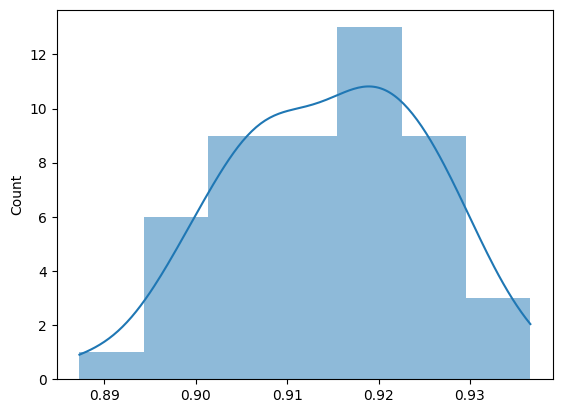

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.neighbors import KNeighborsClassifier

random_states = range(0, 50)

# definer scorer
roc_auc_scorer = make_scorer(roc_auc_score)

# define num folds
k_folds = 10

mean_cv_scores = []

# make many random train/test splits
for rs in random_states:

    # create random (stratified) split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=rs)

    # define model
    model = KNeighborsClassifier(n_neighbors=3)

    # cross-validate for k folds
    scores = cross_val_score(model, X_train, Y_train, cv=k_folds, scoring=roc_auc_scorer)
    
    # aggregate to acquire mean scores
    mean_cv_scores.append(scores.mean())


# plot histogram
sns.histplot(data=mean_cv_scores, kde=True, ec=None)
plt.show()

## Basic Two-sided Hypothesis test

<Axes: ylabel='Count'>

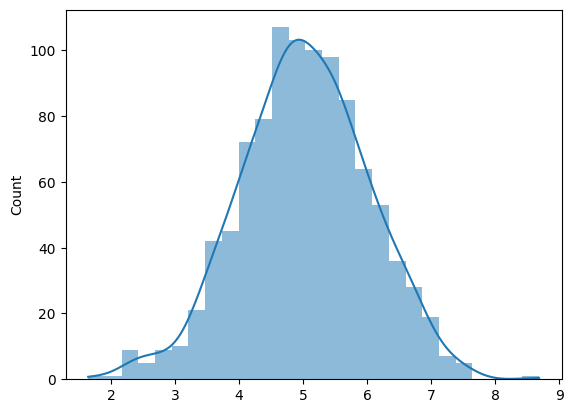

In [49]:
mu = 5
var = 1
N = 1000
sample = np.random.normal(mu, var, size=N)
sns.histplot(data=sample, kde=True, ec=None)

$H_0: \mu = \mu_0$

$H_1: \mu \neq \mu_0$

$
    \text{If}\quad \frac{\sqrt{N} (m - \mu_0)}{\sigma} \in (-1.96, 1.96) \quad\text{ then with 95\% confidence, we fail to reject } H_0
$

In [47]:
sample.mean()

np.float64(3.32)

In [50]:
mu0 = 8
z_stat = N**.5 * (sample.mean() - mu0) / var**.5
print(f"with {mu0=}")
print(f"{z_stat=}")
print(f"falls within 95% interval (-1.96, 1.96)? {'yes, fail to reject H0' if -1.96 < z_stat < 1.96 else 'no, reject H0'}")

print()

mu0 = 5
z_stat = N**.5 * (sample.mean() - mu0) / var**.5
print(f"with {mu0=}")
print(f"{z_stat=}")
print(f"falls within 95% interval (-1.96, 1.96)? {'yes, fail to reject H0' if -1.96 < z_stat < 1.96 else 'no, reject H0'}")


with mu0=8
z_stat=np.float64(-94.20971694132567)
falls within 95% interval (-1.96, 1.96)? no, reject H0

with mu0=5
z_stat=np.float64(0.6586128637257052)
falls within 95% interval (-1.96, 1.96)? yes, fail to reject H0


### T-test

- Practical for a lot of situations
- Only assumption: sample must be approximately normally distributed
- Choose threshold for rejection $\alpha$. For example, $\alpha = 0.05$
- One-sided T-test:
    - assume $H_0: \mu < \mu_0$
    - if $\text{pvalue} < \alpha$, then reject $H_0$, otherwise fail to reject $H_0$
- Two-sided T-test:
    - assume $H_0: \mu = \mu_0$
    - if $\text{pvalue} < \alpha$, then reject $H_0$, otherwise fail to reject $H_0$

In [58]:
from scipy.stats import ttest_1samp

ttest = ttest_1samp(sample, 8)
ttest.statistic, ttest.pvalue

(np.float64(-94.09775146700457), np.float64(0.0))

In [57]:
ttest = ttest_1samp(sample, 5)
ttest

TtestResult(statistic=np.float64(0.6578301217318304), pvalue=np.float64(0.5107988440565758), df=np.int64(999))

### Another example

<Axes: ylabel='Count'>

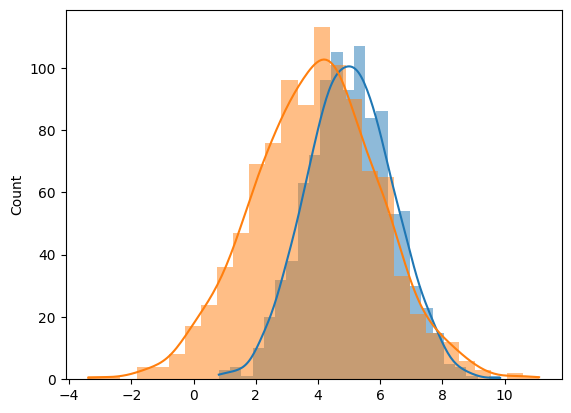

In [59]:
N = 1000

mu_1 = 5
var_1 = 1.4
sample_1 = np.random.normal(mu_1, var_1, size=N)

mu_2 = 4
var_2 = 2
sample_2 = np.random.normal(mu_2, var_2, size=N)

sns.histplot(data=sample_1, kde=True, ec=None)
sns.histplot(data=sample_2, kde=True, ec=None)

In [60]:
from scipy.stats import ttest_ind

ttest = ttest_ind(sample_1, sample_2, equal_var=False)
ttest.statistic, ttest.pvalue

(np.float64(14.13369315079823), np.float64(4.904149555827023e-43))

## Compare multiple classifiers

Assume hyperparameters are already optimized. If not, perform hyperopt search

Decide via T-test which is best:
- Logistic regression
- Decision tree
- K-nearest neighbour

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, make_scorer

# definer scorer
roc_auc_scorer = make_scorer(roc_auc_score)

lr = LogisticRegression()
dt = DecisionTreeClassifier()
knn = KNeighborsClassifier()

lr_auc = []
dt_auc = []
knn_auc = []

random_states = range(100)

k_folds = 5

for rs in random_states:
    
    # create random (stratified) split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, stratify=Y, random_state=rs)

    # cross-validate for k folds
    lr_scores = cross_val_score(lr, X_train, Y_train, cv=k_folds, scoring=roc_auc_scorer)
    lr_auc.append(lr_scores.mean())

    dt_scores = cross_val_score(dt, X_train, Y_train, cv=k_folds, scoring=roc_auc_scorer)
    dt_auc.append(dt_scores.mean())

    knn_scores = cross_val_score(knn, X_train, Y_train, cv=k_folds, scoring=roc_auc_scorer)
    knn_auc.append(knn_scores.mean())

<Axes: ylabel='Count'>

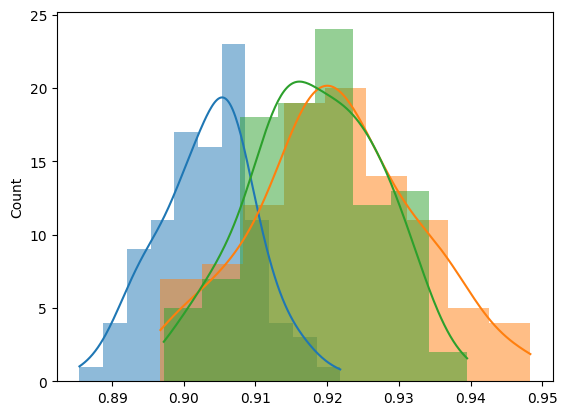

In [62]:
sns.histplot(data=lr_auc, kde=True, ec=None)
sns.histplot(data=dt_auc, kde=True, ec=None)
sns.histplot(data=knn_auc, kde=True, ec=None)

In [63]:
from scipy.stats import ttest_ind

p_values = {}

p_values[f'lr < dt']  = ttest_ind(lr_auc, dt_auc, equal_var=False, alternative='less').pvalue
p_values[f'lr < knn'] = ttest_ind(lr_auc, knn_auc, equal_var=False, alternative='less').pvalue
p_values[f'dt < knn'] = ttest_ind(dt_auc, knn_auc, equal_var=False, alternative='less').pvalue

p_values[f'dt < lr']  = ttest_ind(dt_auc, lr_auc, equal_var=False, alternative='less').pvalue
p_values[f'knn < lr'] = ttest_ind(knn_auc, lr_auc, equal_var=False, alternative='less').pvalue
p_values[f'knn < dt'] = ttest_ind(knn_auc, dt_auc, equal_var=False, alternative='less').pvalue

p_values

{'lr < dt': np.float64(4.824355768936694e-28),
 'lr < knn': np.float64(1.7504616030812458e-28),
 'dt < knn': np.float64(0.9729854524754766),
 'dt < lr': np.float64(1.0),
 'knn < lr': np.float64(1.0),
 'knn < dt': np.float64(0.02701454752452338)}

One important thing to note:

If multiple hypotheses are tested, the probability of observing a rare event increases, and therefore, the likelihood of incorrectly rejecting a null hypothesis (i.e., making a Type I error) increases

Thus apply Bonferonni correction
$$
    \alpha_{\text{corrected}} = \alpha / m
$$
where $m$ is the number of hypotheses that you want to test